In [1]:
#
# !gcloud auth login

In [2]:
# !gcloud storage cp -r gs://data_train_process/train_process/tomo_mean .

Start code


In [3]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm
import cv2
import random
from sklearn.model_selection import train_test_split
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, GlobalAveragePooling2D, Dropout, Dense, Lambda
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
import tensorflow as tf
from tensorflow.image import flip_left_right, rot90


In [4]:

path ='/content/drive/MyDrive/tomo_mean'
# /content/drive/MyDrive/tomo_mean/tomo_003acc/mean_0004.jpg

path_train_csv = '/content/drive/MyDrive/csv_raw/train_labels.csv'

In [5]:

# ===== Cargar y procesar DataFrame ===
df = pd.read_csv(path_train_csv).copy()



# ===== Place where the motor is ==
# df['motor_place'] = np.where(df['Motor_axis_0'] < 0, -1, (df['Motor_axis_0'] / df['Array_shape_axis_0'] * 32).astype(int))
df['motor_place'] = np.where(df['Motor_axis_0'] < 0, -1, (df['Motor_axis_0'] / df['Array_shape_axis_0'] * (df['Array_shape_axis_0'] // 10)).astype(int))
df = df.groupby('tomo_id').first().reset_index()


# ========= 🚮⚠️ ♻️ for small tes of code in 3 tomo's
# tomo_ids = ['tomo_00e047', 'tomo_0fe63f', 'tomo_1e9980']

# prompt: funcion que me de una lista de tomos que no estan vacios en este path /content/drive/MyDrive/tomo_mean/tomo_003acc, quiero saber que tomos tienen info

def find_non_empty_tomos(base_path):

  non_empty_tomos = []
  if not os.path.exists(base_path):
    print(f"Error: Path not found: {base_path}")
    return non_empty_tomos

  for item in os.listdir(base_path):
    item_path = os.path.join(base_path, item)
    if os.path.isdir(item_path):
      # Check if the directory contains any files
      if any(os.path.isfile(os.path.join(item_path, f)) for f in os.listdir(item_path)):
        non_empty_tomos.append(item)
  return non_empty_tomos

# Example usage with your defined 'path'
tomo_ids = find_non_empty_tomos(path)
tomo_ids = tomo_ids[:100]
# print("Tomos with content:", non_empty_tomo_list)
# len (non_empty_tomo_list)

# tomo_ids = ['tomo_00e463', 'tomo_0363f2', 'tomo_081a2d']
df = df[df['tomo_id'].isin(tomo_ids)]

df

,tomo_id,Unnamed: 0,row_id,Motor_axis_0,Motor_axis_1,Motor_axis_2,Array_shape_axis_0,Array_shape_axis_1,Array_shape_axis_2,Voxel_spacing,Number_of_motors,motor_place
0,tomo_003acc,283,0,-1.0,-1.0,-1.0,500,1912,1847,6.5,0,-1
9,tomo_0363f2,406,14,50.0,574.0,392.0,300,960,928,13.1,1,5
19,tomo_081a2d,342,24,152.0,314.0,651.0,300,959,928,15.6,1,15
32,tomo_0de3ee,625,38,131.0,139.0,326.0,500,928,960,13.1,2,13
33,tomo_0e9757,165,40,-1.0,-1.0,-1.0,300,960,928,16.8,0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...
610,tomo_ef1a1a,261,696,-1.0,-1.0,-1.0,300,960,928,19.2,0,-1
611,tomo_efe1f8,590,697,41.0,750.0,427.0,300,960,928,13.1,1,4
612,tomo_f07244,145,698,-1.0,-1.0,-1.0,800,928,960,13.1,0,-1
620,tomo_f6a38a,697,706,227.0,234.0,871.0,500,924,956,19.7,4,22


In [6]:
# ===== Funtion to create the DataBase

def load_motor_images(df, path_base,
                      resize_shape=(512, 512),
                      total_slices=32,
                      num_random_negatives=5
                      ):
    """
    Load images from tomographs based on motor positions.

    Parameters:
    - df: pandas DataFrame containing the metadata
    - path_base: base path where all tomograph folders are located (e.g. '../data/pictures_raw/train')
    - resize_shape: tuple with the resize shape for each image (default: (512, 512))
    - total_slices: number of slices per tomograph (default: 32)
    - num_random_negatives: number of random negative slices to add per sample

    Returns:
    - X: numpy array of images (each image resized)
    - Y: list of labels (1 for motor location, 0 for negatives)
    """
    X = []
    Y = []

    # for idx, row in df.iterrows():
    for idx, row in tqdm(df.iterrows(), total=len(df), desc='Loading images'):

        motor_slice = row['motor_place']
        tomo_id = row['tomo_id']
        total_slices = row['Array_shape_axis_0']//10 ####

        if motor_slice > 0:
            # --- Positive sample ---
            # main_img_path = os.path.join(path_base, tomo_id, f"slice_{motor_slice:04d}.jpg")
            # main_img_path = os.path.join(path_base, tomo_id, f"batch_{motor_slice:02d}.jpg")
            main_img_path = os.path.join(path_base, tomo_id, f"mean_{motor_slice:04d}.jpg")

            if os.path.exists(main_img_path):
              img = cv2.imread(main_img_path, cv2.IMREAD_GRAYSCALE)
              img_resized = cv2.resize(img, resize_shape)
              X.append(img_resized)
              Y.append(1)
            else:
              print( 'no existe')

            # --- Negative samples: motor_slice ±2 ---
            for offset in [-2, +2]:
                neg_slice = motor_slice + offset
                if 0 <= neg_slice < total_slices:
                    # neg_path = os.path.join(path_base, tomo_id, f"slice_{neg_slice:04d}.jpg")
                    neg_path = os.path.join(path_base, tomo_id, f"mean_{neg_slice:04d}.jpg")
                    if os.path.exists(neg_path):
                        img = cv2.imread(neg_path, cv2.IMREAD_GRAYSCALE)
                        img_resized = cv2.resize(img, resize_shape)
                        X.append(img_resized)
                        Y.append(0)

            # --- Random negative samples ---
            possible_slices = list(set(range(total_slices)) - {motor_slice})
            rand_slices = random.sample(possible_slices, min(num_random_negatives, len(possible_slices)))
            for rand_slice in rand_slices:
                # rand_path = os.path.join(path_base, tomo_id, f"slice_{rand_slice:04d}.jpg")
                rand_path = os.path.join(path_base, tomo_id, f"mean_{rand_slice:04d}.jpg")
                if os.path.exists(rand_path):
                    img = cv2.imread(rand_path, cv2.IMREAD_GRAYSCALE)
                    img_resized = cv2.resize(img, resize_shape)
                    X.append(img_resized)
                    Y.append(0)

    X = np.array(X)
    Y = np.array(Y)

    return X, Y


X, y = load_motor_images(df, path_base=path)

X.shape, y.shape

Loading images: 100%|██████████| 100/100 [10:00<00:00,  6.00s/it]


((455, 512, 512), (455,))

In [7]:
print(y)

[1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0
 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0
 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0
 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1
 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 1 0 0 0 0 0 0 0
 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 0 0
 0 0 0 1 0 0 0 0 0 0 0]


In [8]:
# ====== balance of 1 and 0

def augment_positives_to_balance(X, y):
    """
    Augments positive samples (y==1) to balance the number of negative (y==0) samples.

    Augmentations:
    - Add 5% Gaussian noise
    - Rotate 90, 180, 270 degrees
    - Zoom in by 10%

    Parameters:
    - X: numpy array of grayscale images (H, W)
    - y: numpy array of labels (0 or 1)

    Returns:
    - X_balanced: augmented + original images
    - y_balanced: corresponding labels
    """
    X_aug = []
    y_aug = []

    positives = [img for img, label in zip(X, y) if label == 1]
    num_positives = len(positives)
    num_negatives = np.sum(y == 0)

    # How many augmentations we need
    num_needed = num_negatives - num_positives
    if num_needed <= 0:
        return X, y  # Already balanced or over-sampled

    def add_noise(img):
        noise = np.random.normal(0, 0.05 * 255, img.shape).astype(np.float32)
        noisy = np.clip(img.astype(np.float32) + noise, 0, 255).astype(np.uint8)
        return noisy

    def rotate_image(img, angle):
        if angle == 0:
            return img
        return cv2.rotate(img, {
            90: cv2.ROTATE_90_CLOCKWISE,
            180: cv2.ROTATE_180,
            270: cv2.ROTATE_90_COUNTERCLOCKWISE
        }[angle])

    def zoom_image(img, zoom_percent=0.1):
        h, w = img.shape
        zoom_h = int(h * zoom_percent)
        zoom_w = int(w * zoom_percent)
        cropped = img[zoom_h:h-zoom_h, zoom_w:w-zoom_w]
        return cv2.resize(cropped, (w, h))

    transforms = [add_noise,
                  lambda img: rotate_image(img, 90),
                  lambda img: rotate_image(img, 180),
                  lambda img: rotate_image(img, 270),
                  zoom_image]

    while len(y_aug) < num_needed:
        img = random.choice(positives)
        transform = random.choice(transforms)
        img_aug = transform(img)
        X_aug.append(img_aug)
        y_aug.append(1)

    X_balanced = np.concatenate([X, np.array(X_aug)], axis=0)
    y_balanced = np.concatenate([y, np.array(y_aug)], axis=0)

    return X_balanced, y_balanced

X_balaced, y_balanced =augment_positives_to_balance (X , y)
y_balanced

array([1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,

In [9]:
# ===== verification of equilibrium
count_of_ones = np.sum(y_balanced == 0)
print("0's in y_balanced:", count_of_ones, 'over',len (y_balanced) )

0's in y_balanced: 397 over 794


In [10]:
# ====== Add 1 channel to be readeble fro CNN
def reshape_for_cnn(X):
    """
    Reshape grayscale image data to (num_photos, 512, 512, 1)

    Parameters:
    - X: numpy array of shape (num_photos, H, W)

    Returns:
    - X_reshaped: numpy array of shape (num_photos, 512, 512, 1)
    """
    if X.ndim != 3:
        raise ValueError("Input X must be of shape (num_photos, height, width)")

    X_reshaped = X[..., np.newaxis]  # Add channel dimension
    return X_reshaped

X_balaced= reshape_for_cnn(X_balaced)
X_balaced.shape


(794, 512, 512, 1)

In [11]:
# === División del dataset Test, Val ===

X_train, X_test, y_train, y_test = train_test_split(X_balaced, y_balanced, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

In [29]:

from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# === Modelo con DenseNet ===
def init_model_densenet(X):
    original_input_shape = X.shape[1:]
    base_input_shape = original_input_shape[:-1] + (3,) if original_input_shape[-1] == 1 else original_input_shape

    #---- debloq de layers
    base_model = DenseNet121(include_top=False,
                             weights='imagenet',
                             input_shape=base_input_shape)


    # base_model.trainable = False
    # Descongelar algunas capas del modelo base
    for layer in base_model.layers[-20:]:  # Descongelar las últimas 20 capas
        layer.trainable = True

    inputs = Input(shape=original_input_shape)
    x = Lambda(lambda x: tf.image.grayscale_to_rgb(x))(inputs) if original_input_shape[-1] == 1 else inputs

    x = base_model(x, training=False)
    x = GlobalAveragePooling2D()(x)
  # ----  add the regularizer
    # x = Dropout(0.5)(x)
    # x = Dense(128, activation='relu')(x)
    # x = tf.keras.layers.BatchNormalization()(x)
    # x = Dropout(0.3)(x)
    x = Dropout(0.5)(x)
    x = Dense(256, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = Dropout(0.3)(x)

    outputs = Dense(1, activation='sigmoid')(x)

    model = Model(inputs, outputs)
    model.compile(
        loss='binary_crossentropy',
        optimizer=Adam(learning_rate=1e-4),
        metrics=['accuracy',
                 'recall',
                 'precision',
                #  Recall(),
                #  Precision()
                 ]
    )
    return model

# === Entrenamiento ===
def model_train(model, X_train, y_train, batch_size=32, epochs=200):
    es = EarlyStopping(patience=20, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[es],
        verbose=1
    )
    return history

# Inicializa y entrena
model = init_model_densenet(X_train)
history = model_train(model, X_train, y_train)

Epoch 1/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 359s 11s/step - accuracy: 0.5150 - loss: 6.6554 - precision: 0.4489 - recall: 0.5070 - val_accuracy: 0.4302 - val_loss: 6.3863 - val_precision: 1.0000 - val_recall: 0.0192
Epoch 2/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 746ms/step - accuracy: 0.7086 - loss: 6.1929 - precision: 0.6804 - recall: 0.7098 - val_accuracy: 0.4413 - val_loss: 6.2395 - val_precision: 1.0000 - val_recall: 0.0385
Epoch 3/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 745ms/step - accuracy: 0.7279 - loss: 5.9799 - precision: 0.6900 - recall: 0.7716 - val_accuracy: 0.5698 - val_loss: 6.0242 - val_precision: 1.0000 - val_recall: 0.2596
Epoch 4/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 747ms/step - accuracy: 0.8101 - loss: 5.7438 - precision: 0.8122 - recall: 0.7827 - val_accuracy: 0.6760 - val_loss: 5.8122 - val_precision: 1.0000 - val_recall: 0.4423
Epoch 5/200
17/17 ━━━━━━━━━━━━━━━━━━━━ 13s 747ms/step - accuracy: 0.8395 - loss: 5.5661 - precision: 0.8405 - recall: 0.8315 - val_accuracy: 0.6927 - val

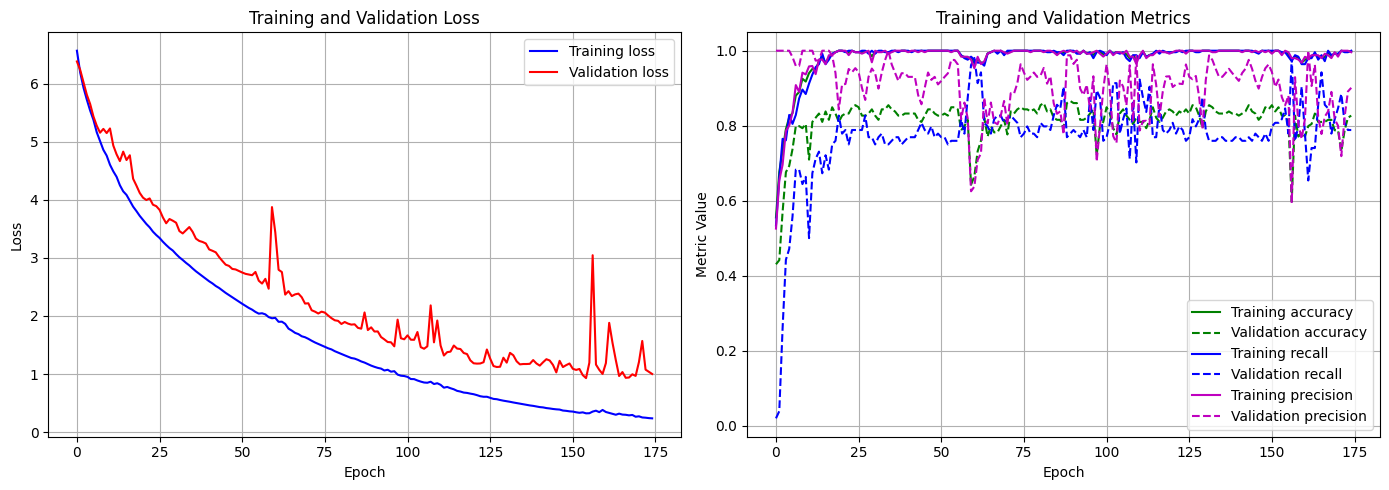

In [30]:
# ==== ploting

def plot_training_metrics(history):

    history_dict = history.history

    # Crear figura con dos subplots
    plt.figure(figsize=(14, 5))

    # --- Primer gráfico: Loss ---
    plt.subplot(1, 2, 1)
    if 'loss' in history_dict:
        plt.plot(history_dict['loss'], 'b-', label='loss')
    if 'val_loss' in history_dict:
        plt.plot(history_dict['val_loss'], 'r-', label='Val loss')

    plt.title('Training and Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # ---
    plt.subplot(1, 2, 2)
    metrics = [
        ('accuracy', 'g', 'accuracy'),
        ('val_accuracy', 'g--', 'Val accuracy'),
        ('recall', 'b', 'recall'),
        ('val_recall', 'b--', 'Val recall'),
        ('precision', 'm', 'precision'),
        ('val_precision', 'm--', 'Val precision')
    ]

    plotted_metrics = False
    for metric, style, label in metrics:
        if metric in history_dict:
            plt.plot(history_dict[metric], style, label=label)
            plotted_metrics = True

    if plotted_metrics:
        plt.title('Training and Validation Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Metric Value')
        plt.legend()
        plt.grid(True)
    else:
        plt.text(0.5, 0.5, 'No metrics found',
                horizontalalignment='center',
                verticalalignment='center',
                transform=plt.gca().transAxes)

    plt.tight_layout()
    plt.show()



plot_training_metrics(history)

In [31]:
accuracy, loss, precision_1, recall_1 = model.evaluate(X_test,y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 4s/step - accuracy: 0.8789 - loss: 0.8064 - precision: 0.8477 - recall: 0.9422


In [32]:
y_pred= model.predict(X_test )
y_pred

3/3 ━━━━━━━━━━━━━━━━━━━━ 24s 6s/step


array([[9.99973774e-01],
       [9.99416351e-01],
       [5.51661197e-03],
       [9.99812901e-01],
       [4.33251401e-03],
       [9.99991894e-01],
       [5.41969808e-03],
       [9.99993205e-01],
       [9.99997735e-01],
       [9.99541759e-01],
       [1.99711751e-02],
       [9.81157839e-01],
       [9.99989986e-01],
       [1.45635828e-02],
       [9.98790443e-01],
       [1.32862911e-01],
       [1.16463073e-01],
       [9.99991894e-01],
       [9.99706089e-01],
       [9.99993682e-01],
       [2.45569670e-03],
       [9.99998689e-01],
       [9.99719799e-01],
       [9.86953139e-01],
       [9.99977946e-01],
       [3.45778525e-01],
       [2.62135535e-01],
       [5.54175019e-01],
       [9.99978185e-01],
       [9.99929547e-01],
       [5.65764904e-02],
       [6.29659295e-01],
       [1.65618025e-02],
       [9.99220014e-01],
       [1.21684335e-02],
       [3.53445020e-03],
       [9.99997735e-01],
       [3.16685589e-04],
       [9.99989033e-01],
       [2.57900654e-04],


In [34]:
from sklearn.metrics import fbeta_score
from sklearn.metrics import classification_report

y_val_pred_prob = model.predict(X_test)
y_val_pred = (y_val_pred_prob > 0.5).astype(int)

fbeta = fbeta_score(y_test, y_val_pred, beta=2)
print(f"F-beta score ponderé (beta=2) en val: {fbeta:.4f}")
print('Repport', classification_report(y_val_pred, y_test))

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 145ms/step
F-beta score ponderé (beta=2) en val: 0.9112
Repport               precision    recall  f1-score   support

           0       0.82      0.91      0.86        34
           1       0.93      0.85      0.89        46

    accuracy                           0.88        80
   macro avg       0.87      0.88      0.87        80
weighted avg       0.88      0.88      0.88        80



In [24]:

# !pip install mlflow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 80.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 132.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 17.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.7/733.7 kB 56.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 19.1 MB/s eta 0:00:00


In [25]:
import mlflow
from sklearn.metrics import fbeta_score

mlflow.set_tracking_uri("http://34.79.119.176:5000")

mlflow.set_experiment("test_Will_colab")  # créé si inexistant

with mlflow.start_run():
    model = init_model_densenet(X_train)
    history = model_train(model, X_train, y_train)

    # Enregistrer le modèle
    mlflow.tensorflow.log_model(model, artifact_path="model")

    # Enregistrer des métriques
    accuracy, loss, precision, recall = model.evaluate(X_test, y_test, verbose=0)
    mlflow.log_metric("test_loss", loss)
    mlflow.log_metric("test_accuracy", accuracy)
    mlflow.log_metric("test_recall", recall)
    mlflow.log_metric("test_precision", precision)

    mlflow.log_param("model_architecture", "Densenet121") #A changer
    mlflow.log_param("epochs", 200)
    # mlflow.log_param("batch_size", 32)
    mlflow.log_param("early_stopping", True)
    mlflow.log_param("loss_function", model.loss)
    mlflow.log_param("optimizer", type(model.optimizer).__name__)
    mlflow.log_param("learning_rate", model.optimizer.learning_rate.numpy())

    y_pred = model.predict(X_test)

    # Si y_pred est un vecteur de probabilités (ex : pour une classe binaire)
    y_pred_labels = (y_pred > 0.5).astype(int)

    fbeta = fbeta_score(y_test, y_pred_labels, beta=2)

    mlflow.log_metric("test_fbeta", fbeta)

2025/06/10 13:23:33 INFO mlflow.tracking.fluent: Experiment with name 'test_Will_colab' does not exist. Creating a new experiment.


Epoch 1/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 50s 862ms/step - accuracy: 0.4765 - loss: 2.3401 - precision_2: 0.4506 - recall_2: 0.5067 - val_accuracy: 0.6034 - val_loss: 0.7665 - val_precision_2: 0.6667 - val_recall_2: 0.6346
Epoch 2/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.5789 - loss: 1.5766 - precision_2: 0.5926 - recall_2: 0.5232 - val_accuracy: 0.6480 - val_loss: 0.6880 - val_precision_2: 0.7113 - val_recall_2: 0.6635
Epoch 3/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 121ms/step - accuracy: 0.5708 - loss: 1.7526 - precision_2: 0.5508 - recall_2: 0.5379 - val_accuracy: 0.6704 - val_loss: 0.7029 - val_precision_2: 0.8571 - val_recall_2: 0.5192
Epoch 4/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.5778 - loss: 1.6786 - precision_2: 0.5694 - recall_2: 0.5200 - val_accuracy: 0.6816 - val_loss: 0.5838 - val_precision_2: 0.6822 - val_recall_2: 0.8462
Epoch 5/200
34/34 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.5616 - loss: 1.3867 - precision_2: 0.5023 - recall_2: 0.

2025/06/10 13:26:28 WARNING mlflow.tensorflow: You are saving a TensorFlow Core model or Keras model without a signature. Inference with mlflow.pyfunc.spark_udf() will not work unless the model's pyfunc representation accepts pandas DataFrames as inference inputs.
2025/06/10 13:26:39 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /tmp/tmp9t3nv9dy/model, flavor: tensorflow). Fall back to return ['tensorflow==2.18.0', 'cloudpickle==3.1.1']. Set logging level to DEBUG to see the full traceback. 
2025/06/10 13:26:39 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


🏃 View run glamorous-ant-573 at: http://34.79.119.176:5000/#/experiments/9/runs/346728ea055b43cfa8fe6fbf5227831a
🧪 View experiment at: http://34.79.119.176:5000/#/experiments/9


NameError: name 'precision1' is not defined